#MATH210 Final Project - Perceptron

##Importing Python Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

##Activation Functions

###Sigmoid Function

In [ ]:
def sigmoid(x, derivative: bool = False):
    """
    sigmoid function

    :param x: numeric input
    :param derivative: function derivative or original function
    """
    sig = 1 / (1 + np.exp(-x))
    if derivative:
        return sig * (1 - sig)
    else:
        return sig

###Hyperbolic Tangent Function

In [ ]:
def sech(x):
    """
    hyperbolic secant function
    
    :param x: numeric input
    """
    return 2 / (np.exp(x) + np.exp(-x))


def tanh(x, derivative: bool = False):
    """
    hyperbolic tangent function

    :param x: numeric input
    :param derivative: function derivative or original function
    """
    if derivative:
        return sech(x)**2
    else:
        return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)

###ReLU Function

In [ ]:
def relu(x, derivative: bool = False):
    """
    reLU function

    :param x: numeric input
    :param derivative: function derivative or original function
    """
    if derivative:
        return 0 if x < 0 else 1
    else:
        return max(0.0, x)

##Perceptron

In [ ]:
class Perceptron:
    """
    Perceptron class

    Implementation of a Perceptron classifier using the mean squared error (MSE)
    loss function

    Properties:
        weights
            weights of the features
        n_epochs
            number of epochs required to reach the stopping criterion
        n_features_in
            number of features in the input data
        n_features
            number of features used by the model
    Private Attributes:
        __max_epochs: int
            the maximum number of iterations during fitting
        __tol: float
            the stopping criterion (tol > previous loss - current loss)
        __learn_rate: float
            the learning rate
        __fun
            the activation function
        __neg_val
            value of negative prediction for activation function
        __thres
            threshold for positive and negative predictions
    Methods:
        __init__(max_epochs, tol, learn_rate, activation_function)
        fit(X, y, degree)
        predict(X)
        get_params()
    """
    def __init__(
            self,
            max_epochs: int = 100,
            tol: float = 1E-3,
            learn_rate: float = 1.0,
            activation_function: str = 'sigmoid'):
        """
        Perceptron class constructor

        :param max_epochs: maximum number of passes over the data
        :param tol: stopping criterion, epochs stop when (tol > change in loss)
        :param learn_rate: learning rate of classifier
        :param activation_function: activation function (sigmoid, tanh, relu)
        """
        if max_epochs < 0:
            raise ValueError('invalid maximum epoch')
        if tol < 0.0:
            raise ValueError('invalid tolerance')
        if learn_rate <= 0.0 or learn_rate > 1.0:
            raise ValueError('invalid learning rate')
        if activation_function == 'sigmoid':
            self.__fun = sigmoid
            self.__neg_val = 0
            self.__thres = 0.5
        elif activation_function == 'tanh':
            self.__fun = tanh
            self.__neg_val = -1
            self.__thres = 0
        elif activation_function == 'relu':
            self.__fun = relu
            self.__neg_val = 0
            self.__thres = 0
        else:
            raise ValueError('invalid activation function')
        self.__max_epochs = max_epochs
        self.__tol = tol
        self.__learn_rate = learn_rate
        self._degree = None
        self._weights = None
        self._n_epochs = None
        self._n_feat_in = None
        self._n_feat = None

    def fit(self, X: np.ndarray, y: np.ndarray, degree: int = 1):
        """
        fit Perceptron classifier using training data

        :param X: training data
        :param y: target values
        :param degree: degree of polynomial features
        """
        data_points, initial_features = X.shape
        if y.ndim != 1:
            raise ValueError('invalid target values')
        if data_points != y.size:
            raise ValueError('incompatible data and values')
        if degree < 1:
            raise ValueError('invalid polynomial features')

        # shift target values for activation function
        y_shifted = np.array([1 if i == 1 else self.__neg_val for i in y])

        # generate polynomial features
        poly_feat = PolynomialFeatures(degree)
        X_poly = poly_feat.fit_transform(X)
        features = poly_feat.n_output_features_
        self._degree = degree
        self._n_feat_in = initial_features
        self._n_feat = features
        self._n_epochs = 0

        # initialize weights
        self._weights = np.random.randn(features) * np.sqrt(1 / features)
        self._weights[0] = 0
        prev_loss = None

        # calculate gradient and adjust weights until stopping criterion is met
        while self._n_epochs < self.__max_epochs:
            gradient = np.zeros(features)
            loss = 0.0
            
            # calculate gradient and loss for each data point
            for i in range(data_points):
                output = np.dot(self._weights, X_poly[i])
                prediction = self.__fun(output)
                error = prediction - y_shifted[i]
                loss += error ** 2
                gradient_term = error * self.__fun(output, derivative = True)
                gradient += gradient_term * X_poly[i]

            # update weights
            self._weights -= self.__learn_rate * gradient / data_points
            self._n_epochs += 1
            loss /= data_points

            # check stopping criterion
            if prev_loss is not None:
                if loss < prev_loss and self.__tol > (prev_loss - loss):
                    break
            prev_loss = loss
    
    def predict(self, X: np.ndarray):
        """
        predict classification labels

        :param X: data to make predictions on
        """
        poly_feat = PolynomialFeatures(self._degree)
        X_poly = poly_feat.fit_transform(X)
        rows, columns = X_poly.shape
        if columns != self._n_feat:
            raise ValueError('invalid data')
        predictions = np.zeros(rows)

        # generate outputs, convert to predictions
        for i in range(rows):
            output = self.__fun(np.dot(self._weights, X_poly[i]))
            predictions[i] = 1 if output > self.__thres else 0
        return predictions
    
    @property
    def weights(self):
        """
        weights assigned to the features
        """
        return np.copy(self._weights)

    @property
    def n_epochs(self):
        """
        actual number of epochs to reach the stopping criterion
        """
        return self._n_epochs

    @property
    def n_features_in(self):
        """
        number of features in the input data
        """
        return self._n_feat_in

    @property
    def n_features(self):
        """
        number of features used by the model
        """
        return self._n_feat - 1

    def get_params(self):
        """
        prints the private parameters of Perceptron classifier
        """
        print('Maximum Number of Epochs: ', self.__max_epochs)
        print('Tolerance: ', self.__tol)
        print('Learning Rate: ', self.__learn_rate)
        print('Activation Function: ', self.__fun.__name__)

##Testing Perceptron Model

###Functions for Plotting

In [ ]:
def scatter(X: np.ndarray, y: np.ndarray):
    """
    create scatter plot of data

    :param X: data to plot
    :param y: marker colors
    """
    plt.scatter(X[:,0], X[:,1], c = y, cmap = plt.cm.Paired)


def plot_decision_region(X: np.ndarray, y: np.ndarray, clf: Perceptron):
    """
    plot decision region of Perceptron model
    
    Code from: https://stackoverflow.com/questions/19054923/plot-decision-boundary-matplotlib

    :param X: input data
    :param y: target values
    :param clf: trained Perceptron model
    """
    step = 0.01  # mesh step size
    x_1_min = X[:,0].min() - 1
    x_1_max = X[:,0].max() + 1
    x_2_min = X[:,1].min() - 1
    x_2_max = X[:,1].max() + 1

    # create mesh
    x_1 = np.arange(x_1_min, x_1_max, step)
    x_2 = np.arange(x_2_min, x_2_max, step)
    x1, x2 = np.meshgrid(x_1, x_2)
    zz = clf.predict(np.c_[np.ravel(x1), np.ravel(x2)])

    # plot decision region
    plt.contourf(x1, x2, zz.reshape(x1.shape))

    # plot original data
    scatter(X, y)

###Linearly Separable Data Example

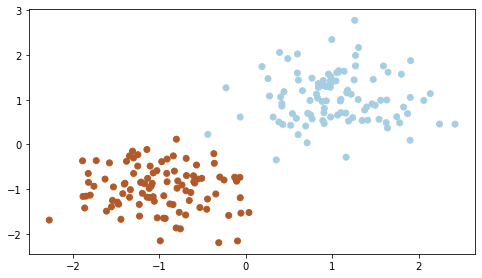

In [ ]:
# randomly generate linearly separable dataset
samples = 100
X_1 = np.random.normal(loc = 1.0, scale = 0.5, size = (samples, 2))
X_2 = np.random.normal(loc = -1.0, scale = 0.5, size = (samples, 2))
y_1 = np.zeros(samples)
y_2 = np.ones(samples)
X = np.vstack((X_1, X_2))
y = np.hstack((y_1, y_2))
scatter(X, y)

In [ ]:
# train Perceptron model
clf = Perceptron(max_epochs = 200, tol = 1E-5, activation_function = 'tanh')
clf.fit(X, y)
print(clf.n_epochs)

200


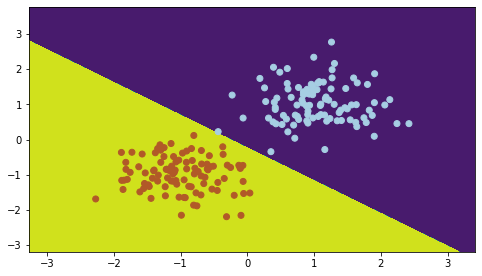

In [ ]:
# plot decision region
plot_decision_region(X, y, clf)

###Non-Linearly Separable Data Example 1

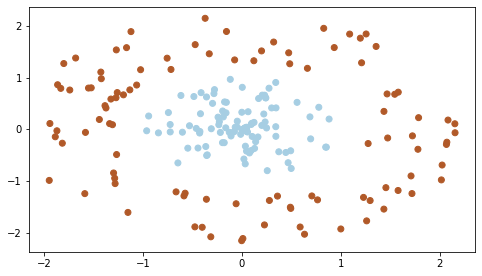

In [ ]:
# randomly generate non-linearly separable dataset
samples = 100
interval = 0.5
radius_1 = interval
radius_2 = radius_1 + 2.5 * interval
r_1 = 2 * interval * np.random.rand(samples) + radius_1 - interval
r_2 = 2 * interval * np.random.rand(samples) + radius_2 - interval
theta_1 = 2 * np.pi * np.random.rand(samples)
theta_2 = 2 * np.pi * np.random.rand(samples)
X_1 = np.zeros((samples, 2))
X_2 = np.zeros((samples, 2))
for i in range(samples):
    X_1[i,0] = r_1[i] * np.cos(theta_1[i])
    X_1[i,1] = r_1[i] * np.sin(theta_1[i])
    X_2[i,0] = r_2[i] * np.cos(theta_2[i])
    X_2[i,1] = r_2[i] * np.sin(theta_2[i])
y_1 = np.zeros(samples)
y_2 = np.ones(samples)
X = np.vstack((X_1, X_2))
y = np.hstack((y_1, y_2))
scatter(X, y)

In [ ]:
# train linear Perceptron model
clf = Perceptron(activation_function = 'tanh')
clf.fit(X, y)
print(clf.n_epochs)

10


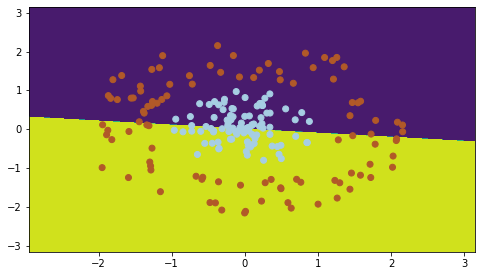

In [ ]:
# plot decision region
plot_decision_region(X, y, clf)

In [ ]:
# train quadratic Perceptron model
clf = Perceptron(activation_function = 'tanh')
clf.fit(X, y, degree = 2)
print(clf.n_epochs)

34


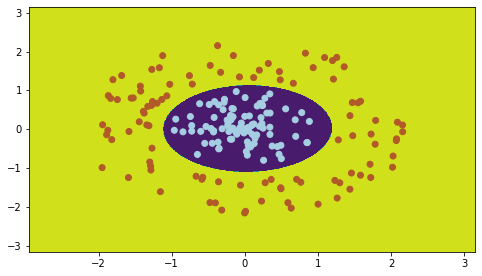

In [ ]:
# plot decision region
plot_decision_region(X, y, clf)

In [ ]:
# train cubic Perceptron model
clf = Perceptron(activation_function = 'tanh')
clf.fit(X, y, degree = 3)
print(clf.n_epochs)

32


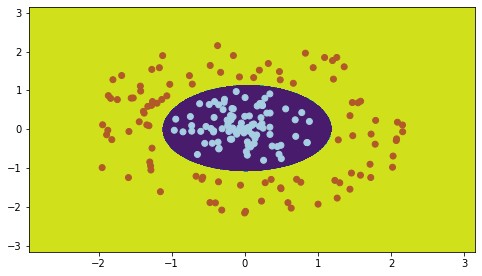

In [ ]:
# plot decision region
plot_decision_region(X, y, clf)

###Non-Linearly Separable Data Example 2

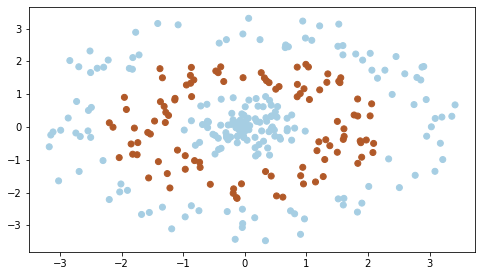

In [ ]:
# randomly generate non-linearly separable dataset
samples = 100
interval = 0.5
radius_1 = interval
radius_2 = radius_1 + 2.5 * interval
radius_3 = radius_2 + 2.5 * interval
r_1 = 2 * interval * np.random.rand(samples) + radius_1 - interval
r_2 = 2 * interval * np.random.rand(samples) + radius_2 - interval
r_3 = 2 * interval * np.random.rand(samples) + radius_3 - interval
theta_1 = 2 * np.pi * np.random.rand(samples)
theta_2 = 2 * np.pi * np.random.rand(samples)
theta_3 = 2 * np.pi * np.random.rand(samples)
X_1 = np.zeros((samples, 2))
X_2 = np.zeros((samples, 2))
X_3 = np.zeros((samples, 2))
for i in range(samples):
    X_1[i,0] = r_1[i] * np.cos(theta_1[i])
    X_1[i,1] = r_1[i] * np.sin(theta_1[i])
    X_2[i,0] = r_2[i] * np.cos(theta_2[i])
    X_2[i,1] = r_2[i] * np.sin(theta_2[i])
    X_3[i,0] = r_3[i] * np.cos(theta_3[i])
    X_3[i,1] = r_3[i] * np.sin(theta_3[i])
y_1 = np.zeros(samples)
y_2 = np.ones(samples)
y_3 = np.zeros(samples)
X = np.vstack((X_1, X_2, X_3))
y = np.hstack((y_1, y_2, y_3))
scatter(X, y)

In [ ]:
# train linear Perceptron model
clf = Perceptron(tol = 1E-6, activation_function = 'tanh')
clf.fit(X, y)
print(clf.n_epochs)

36


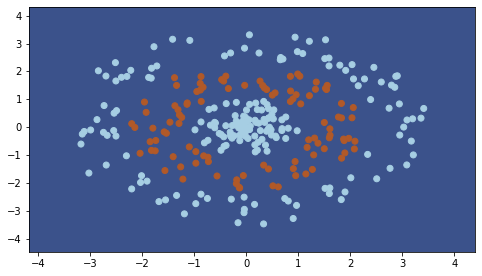

In [ ]:
# plot decision region
plot_decision_region(X, y, clf)

In [ ]:
# train quadratic Perceptron model
clf = Perceptron(max_epochs = 200, tol = 1E-5, activation_function = 'tanh')
clf.fit(X, y, degree = 2)
print(clf.n_epochs)

200


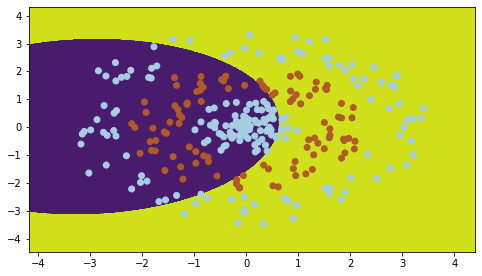

In [ ]:
# plot decision region
plot_decision_region(X, y, clf)

In [ ]:
# train cubic Perceptron model
clf = Perceptron(max_epochs = 10000, tol = 1E-8, activation_function = 'tanh')
clf.fit(X, y, degree = 3)
print(clf.n_epochs)

10000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


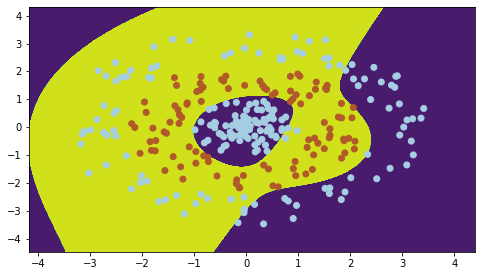

In [ ]:
# plot decision region
plot_decision_region(X, y, clf)

In [ ]:
# train quartic Perceptron model
clf = Perceptron(max_epochs = 500, tol = 1E-5, activation_function = 'tanh')
clf.fit(X, y, degree = 4)
print(clf.n_epochs)

390


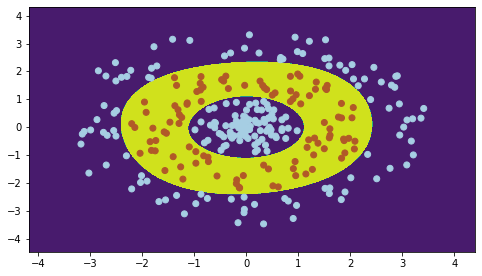

In [ ]:
# plot decision region
plot_decision_region(X, y, clf)